# **Importing the Data**

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense

In [163]:
data1 = pd.read_csv("BETN073-1990_2012.csv")
data2 = pd.read_csv("BETN073-2013_2022.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

## Making Concentration values NA for validity = 0 and validity = 1 

In [164]:
ozone_data.head()

,index,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,0,BE/SPO-BETN073_00007_100,7,1990-01-01T00:00:00,1990-01-01T01:00:00,47.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
1,1,BE/SPO-BETN073_00007_100,7,1990-01-01T01:00:00,1990-01-01T02:00:00,46.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
2,2,BE/SPO-BETN073_00007_100,7,1990-01-01T02:00:00,1990-01-01T03:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
3,3,BE/SPO-BETN073_00007_100,7,1990-01-01T03:00:00,1990-01-01T04:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
4,4,BE/SPO-BETN073_00007_100,7,1990-01-01T04:00:00,1990-01-01T05:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN


In [165]:
ozone_data['Validity'].unique()

array([ 1, -1,  0], dtype=int64)

In [166]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [167]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [168]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [169]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2008) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [170]:
data.head()

,Start,Concentration
0,2008-01-01 00:00:00,0.0
1,2008-01-01 01:00:00,1.0
2,2008-01-01 02:00:00,0.0
3,2008-01-01 03:00:00,2.0
4,2008-01-01 04:00:00,1.0


The data is checked to make sure there are no duplicates.

In [171]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [172]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2008-01-01 00:00:00            0.0  2008      1    1  00:00:00
1 2008-01-01 01:00:00            1.0  2008      1    1  01:00:00
2 2008-01-01 02:00:00            0.0  2008      1    1  02:00:00
3 2008-01-01 03:00:00            2.0  2008      1    1  03:00:00
4 2008-01-01 04:00:00            1.0  2008      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [173]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [174]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2008-01-01 00:00:00,0.0,2008,1,1,00:00:00,2,0
1,2008-01-01 01:00:00,1.0,2008,1,1,01:00:00,2,0
2,2008-01-01 02:00:00,0.0,2008,1,1,02:00:00,2,0
3,2008-01-01 03:00:00,2.0,2008,1,1,03:00:00,2,0
4,2008-01-01 04:00:00,1.0,2008,1,1,04:00:00,2,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [175]:
# Can check the issue here
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

In [176]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [177]:
data['Concentration'].isna().sum()

5381

Thus, there are 5381 missing observation for the BETN073 station between the years 2008 and 2019.

In [178]:
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

## Making the data daily

In [179]:
# Remove the 'Time' column
data.drop(columns=['Time'], inplace=True)

# Group by 'Year', 'Month', and 'Day', and calculate the daily average concentration
data = data.groupby(['Year', 'Month', 'Day']).agg({'Concentration': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

# Display the daily dataset
print(data.head())

   Year  Month  Day  Concentration  DayOfWeek  Weekend
0  2008      1    1           25.0          2        0
1  2008      1    2           51.0          3        0
2  2008      1    3           42.0          4        0
3  2008      1    4           49.0          5        0
4  2008      1    5           71.0          6        1


In [180]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 49


In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4354 entries, 0 to 4353
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4354 non-null   int64  
 1   Month          4354 non-null   int64  
 2   Day            4354 non-null   int64  
 3   Concentration  4305 non-null   float64
 4   DayOfWeek      4354 non-null   int64  
 5   Weekend        4354 non-null   int32  
dtypes: float64(1), int32(1), int64(4)
memory usage: 187.2 KB


In [182]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
42    2008      2   12            NaN          2        0
43    2008      2   13            NaN          3        0
44    2008      2   14            NaN          4        0
138   2008      5   18            NaN          0        1
448   2009      3   24            NaN          2        0
449   2009      3   25            NaN          3        0
658   2009     10   20            NaN          2        0
659   2009     10   21            NaN          3        0
1854  2013      2   26            NaN          2        0
1855  2013      2   27            NaN          3        0
1856  2013      2   28            NaN          4        0
1984  2013      7    6            NaN          6        1
1985  2013      7    7            NaN          0        1
1999  2013      7   21            NaN          0        1
2061  2013      9   21            NaN          6        1
2062  2013      9   22            NaN          0  

In [183]:
#data['Concentration'] = np.interp(data.index, data.dropna().index, data['Concentration'].dropna())

In [184]:
#nan_count = data['Concentration'].isna().sum()
#print("Number of NaN values in 'Concentration':", nan_count)

In [185]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend
Date,,,,,,
2008-01-01,2008,1,1,25.0,2,0
2008-01-02,2008,1,2,51.0,3,0
2008-01-03,2008,1,3,42.0,4,0
2008-01-04,2008,1,4,49.0,5,0
2008-01-05,2008,1,5,71.0,6,1


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [186]:
### We first create a new dataset,interpolate the missing values so that we can perform ARIMA
# Assuming data is your DataFrame
data_a = data.copy()

In [187]:
data_a['Concentration'] = data_a['Concentration'].interpolate(method='linear')

In [188]:
# Assuming data_a is your DataFrame
columns_to_drop = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend']

# Drop the specified columns from data_a
data_a = data_a.drop(columns=columns_to_drop)

data_a.isna().sum()
data_a.head()

,Concentration
Date,
2008-01-01,25.0
2008-01-02,51.0
2008-01-03,42.0
2008-01-04,49.0
2008-01-05,71.0


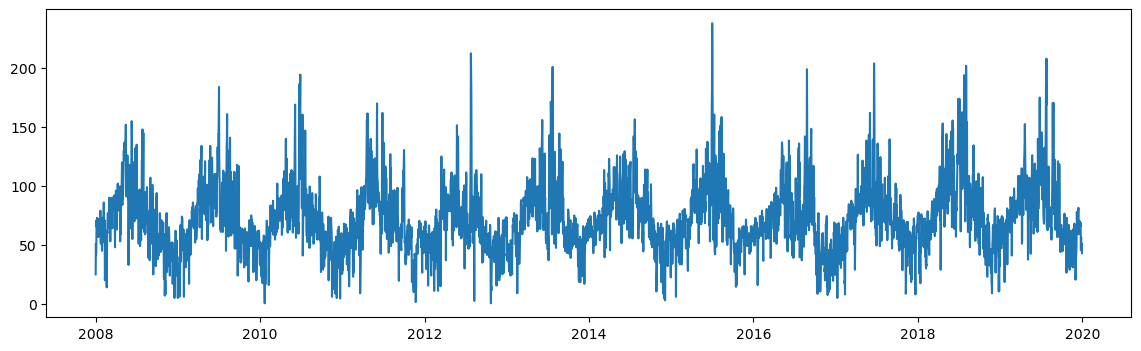

In [189]:
plt.figure(figsize=(14,4))
plt.plot(data_a.Concentration)

In [190]:
data_b = data_a.copy()
data_b = data_b.reset_index()

In [191]:
data_b

,Date,Concentration
0,2008-01-01,25.0
1,2008-01-02,51.0
2,2008-01-03,42.0
3,2008-01-04,49.0
4,2008-01-05,71.0
...,...,...
4349,2019-12-27,56.5
4350,2019-12-28,46.5
4351,2019-12-29,51.0
4352,2019-12-30,46.0


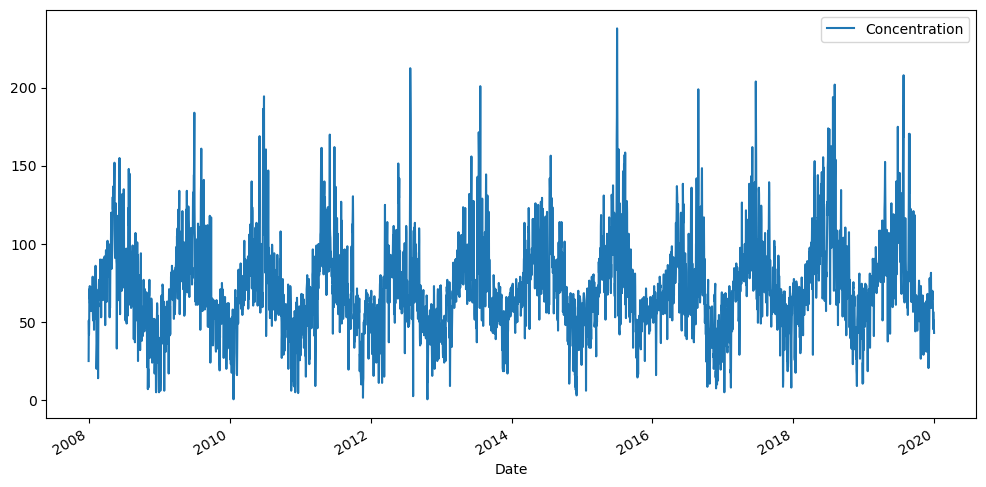

In [192]:
data_b['Date'] = pd.to_datetime(data_b['Date'])  # Convert date column to DateTime
ax = data_b.plot(x='Date', y='Concentration', figsize=(12, 6))

plt.show()

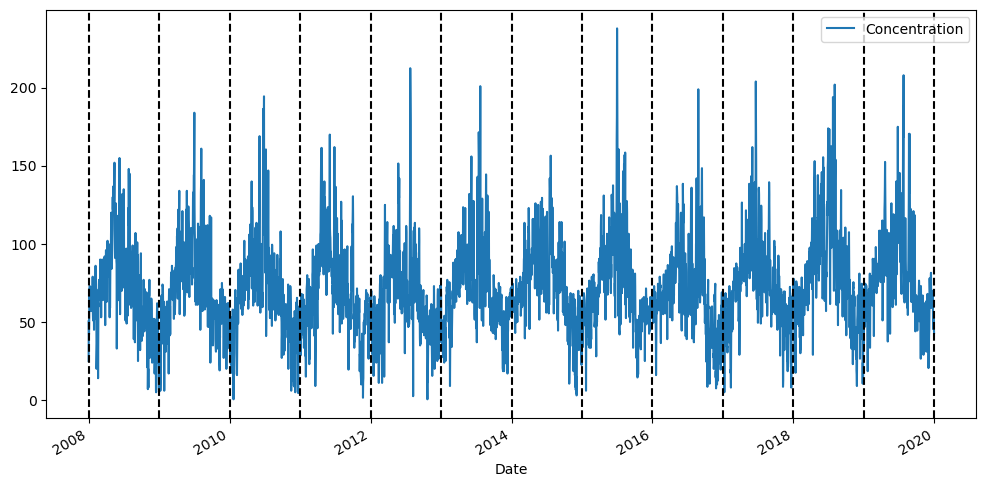

In [193]:
ax = data_b.plot(x='Date', y='Concentration', figsize=(12,6))
xcoords = ['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

##### We can slightly observe seasonality

In [194]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [195]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -5.744103589884451
p-value: 6.178462457677176e-07
Critical Values: {'1%': -3.4318600803649013, '5%': -2.862207269624908, '10%': -2.567125192310325}
The time series is likely stationary.


## Analysed stationarity

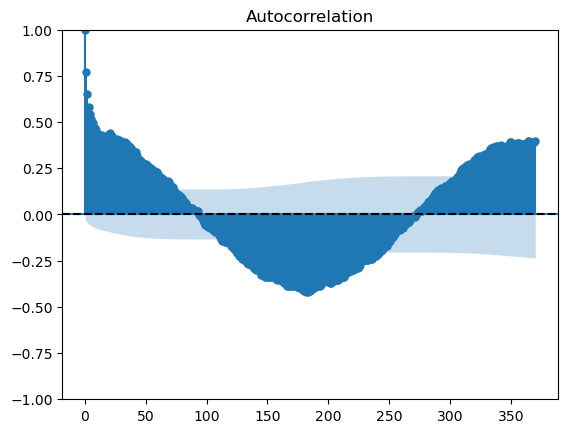

In [196]:
acf_plot = plot_acf(data_a.Concentration, lags=370)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


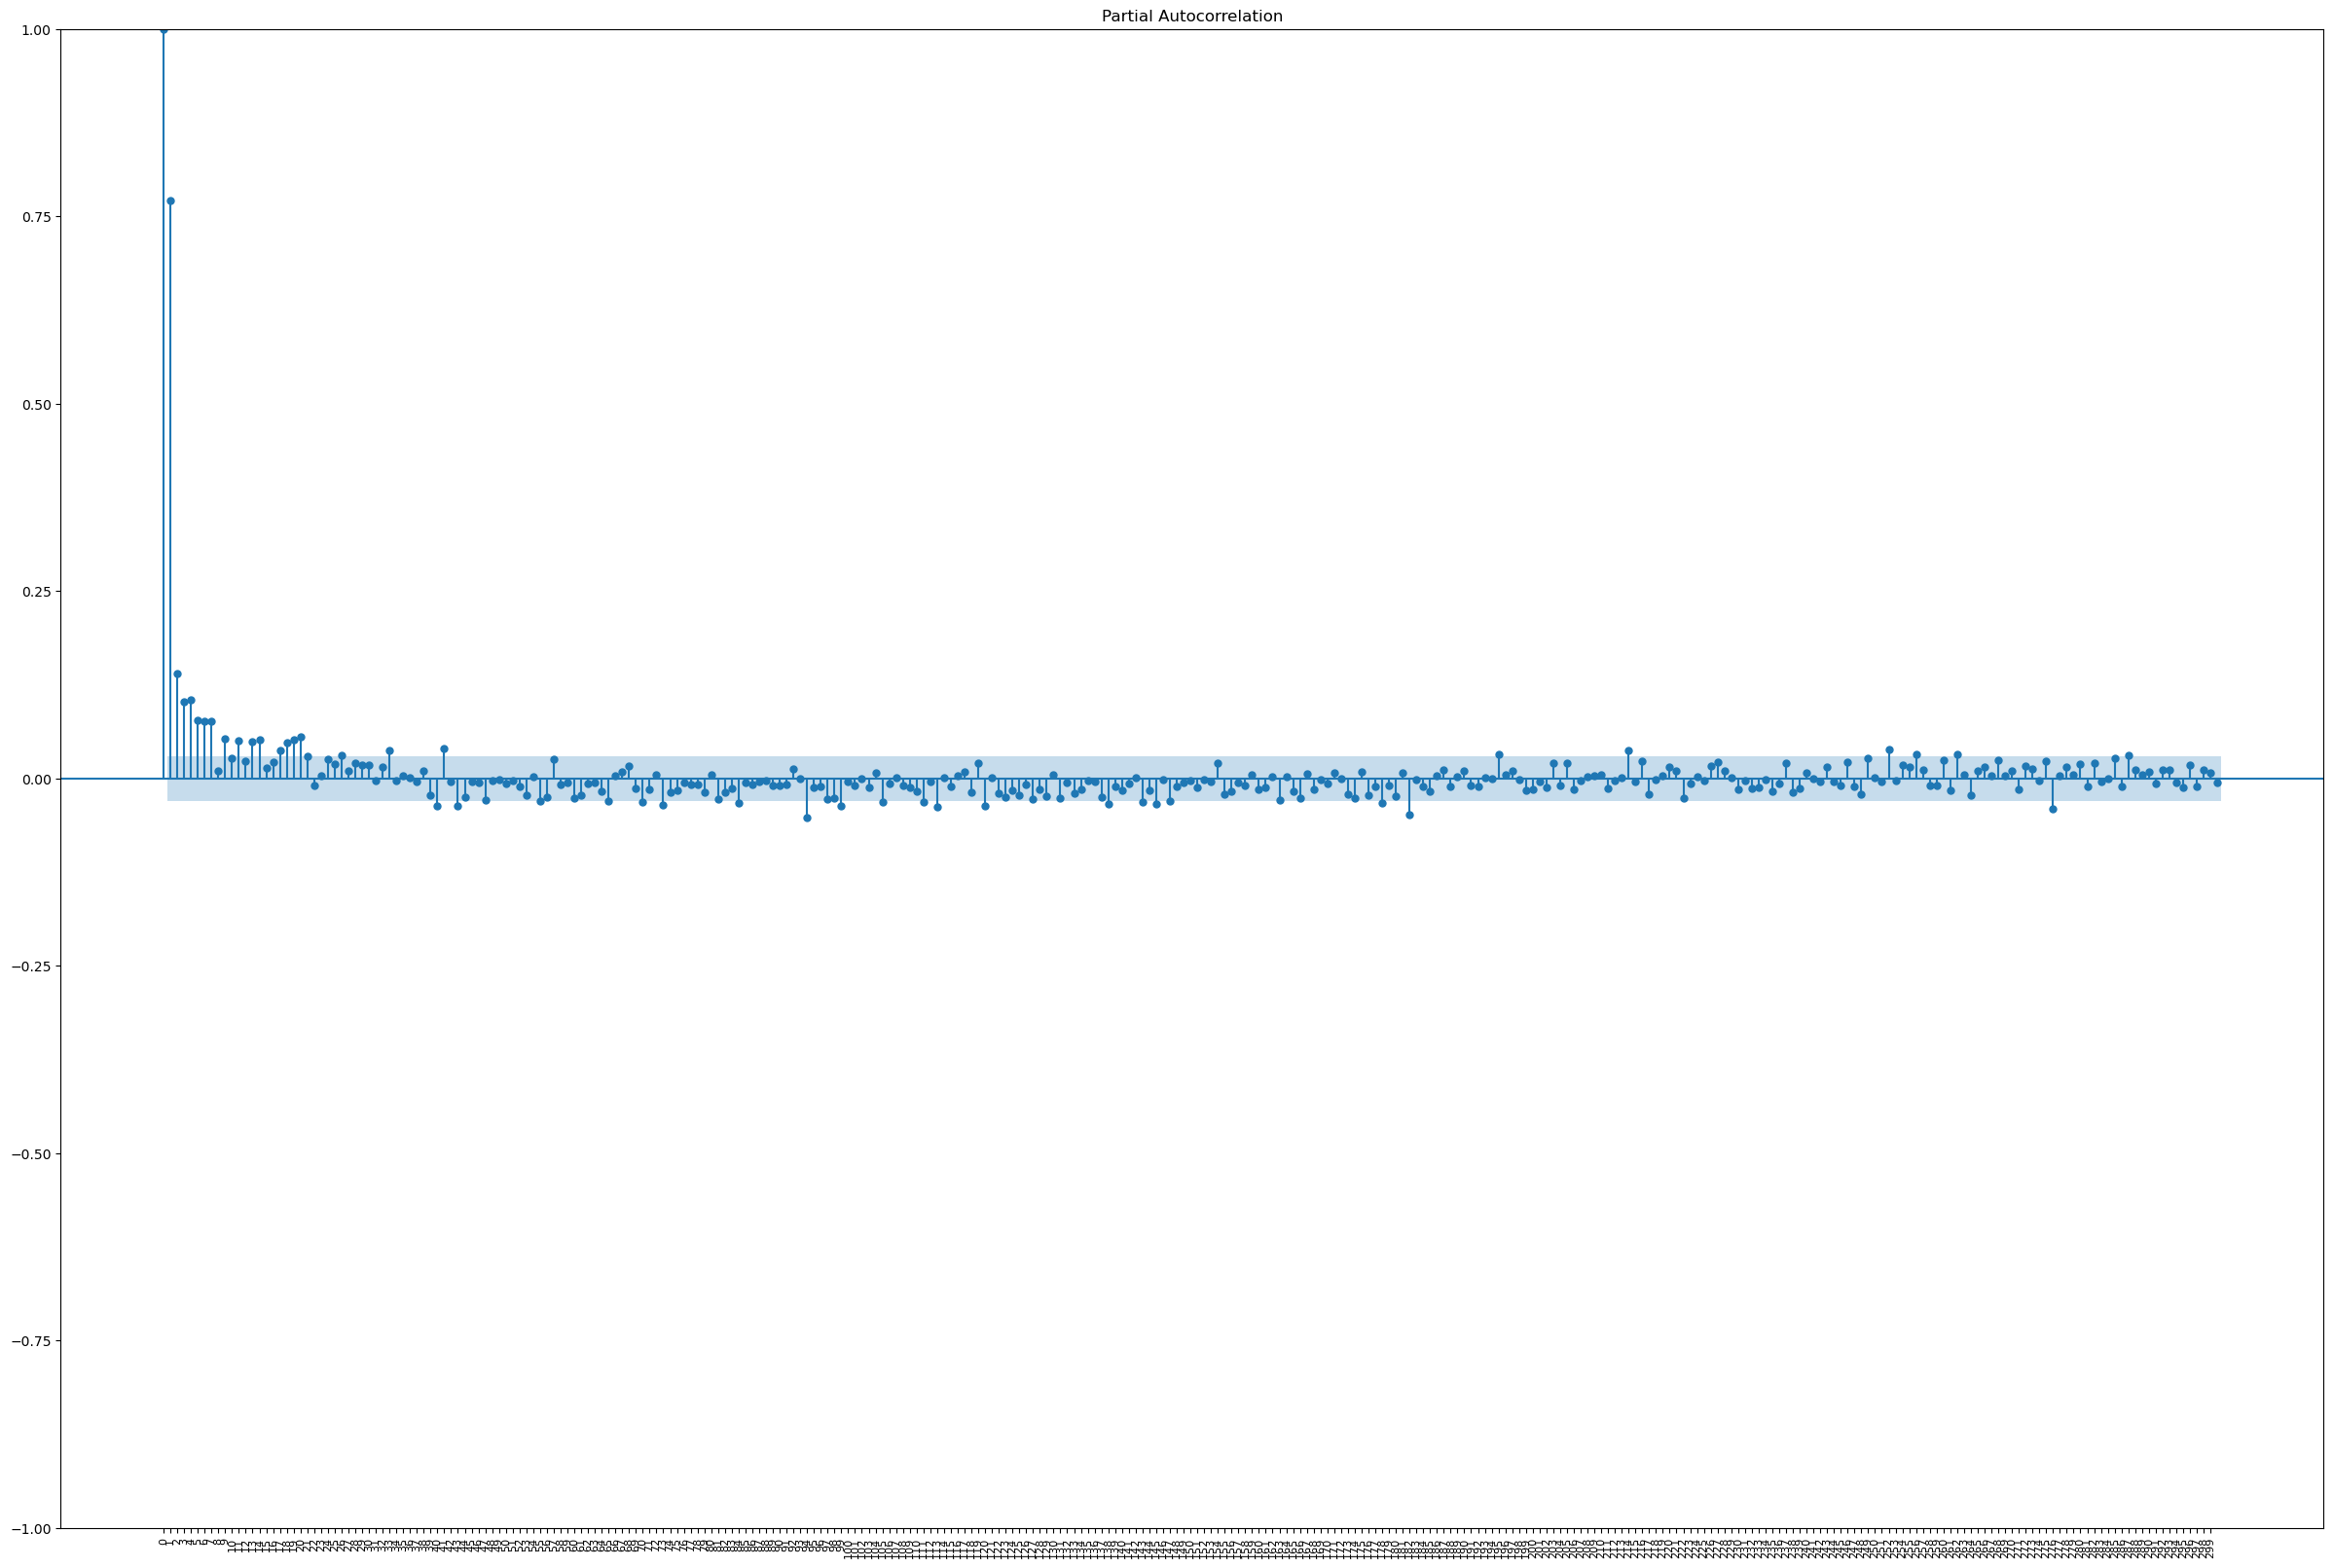

In [197]:
# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(data_a['Concentration'], lags=300, ax=ax)

# Display the plot
plt.xticks(range(300), rotation='vertical', fontsize=8)
plt.show()

In [142]:
# Define the range of AR, MA, and seasonality values to check
ar_range = range(12)
ma_range = range(12)

# Initialize variables for tracking the best model
best_mse = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a['Concentration'], fitted_values)

        # Check if the current model has a lower MSE than the best so far
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_results = results

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_results.aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())

C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

Best Model Order: (2, 0, 10)
Best Model AIC: 37349.45
Best Model BIC: 37438.76
Best Model MSE: 309.08
                               SARIMAX Results                                
Dep. Variable:          Concentration   No. Observations:                 4354
Model:                ARIMA(2, 0, 10)   Log Likelihood              -18660.727
Date:                Sun, 03 Mar 2024   AIC                          37349.453
Time:                        09:36:35   BIC                          37438.757
Sample:                             0   HQIC                         37380.973
                               - 4354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.0177      2.418     28.959      0.000      65.279      74.757
ar.L1          1.9897      0.

In [198]:
# Fit ARMA (2, 0, 10)
order_arma = (2, 0, 10)  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a['Concentration'], order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues
Date                                                                         
2008-01-01  2008      1    1           25.0          2        0     70.017711
2008-01-02  2008      1    2           51.0          3        0     36.954496
2008-01-03  2008      1    3           42.0          4        0     52.626476
2008-01-04  2008      1    4           49.0          5        0     46.921039
2008-01-05  2008      1    5           71.0          6        1     50.848344
...          ...    ...  ...            ...        ...      ...           ...
2019-12-27  2019     12   27           56.5          5        0     50.151538
2019-12-28  2019     12   28           46.5          6        1     55.939282
2019-12-29  2019     12   29           51.0          0        1     50.456584
2019-12-30  2019     12   30           46.0          1        0     52.278797
2019-12-31  2019     12   31           43.0          2        0 

##### The model is valid, the jung-box test shows  0.43 > 0.05

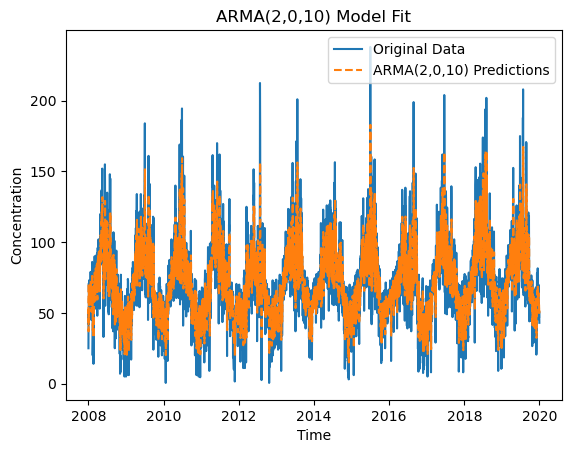

In [199]:
# Plot original data and predicted values
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(2,0,10) Predictions', linestyle='--')
plt.title('ARMA(2,0,10) Model Fit')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

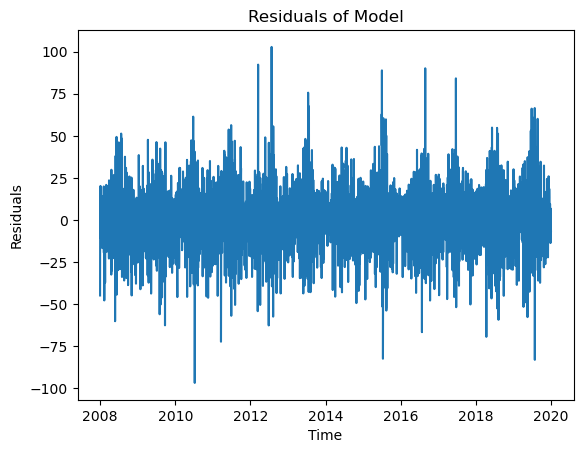

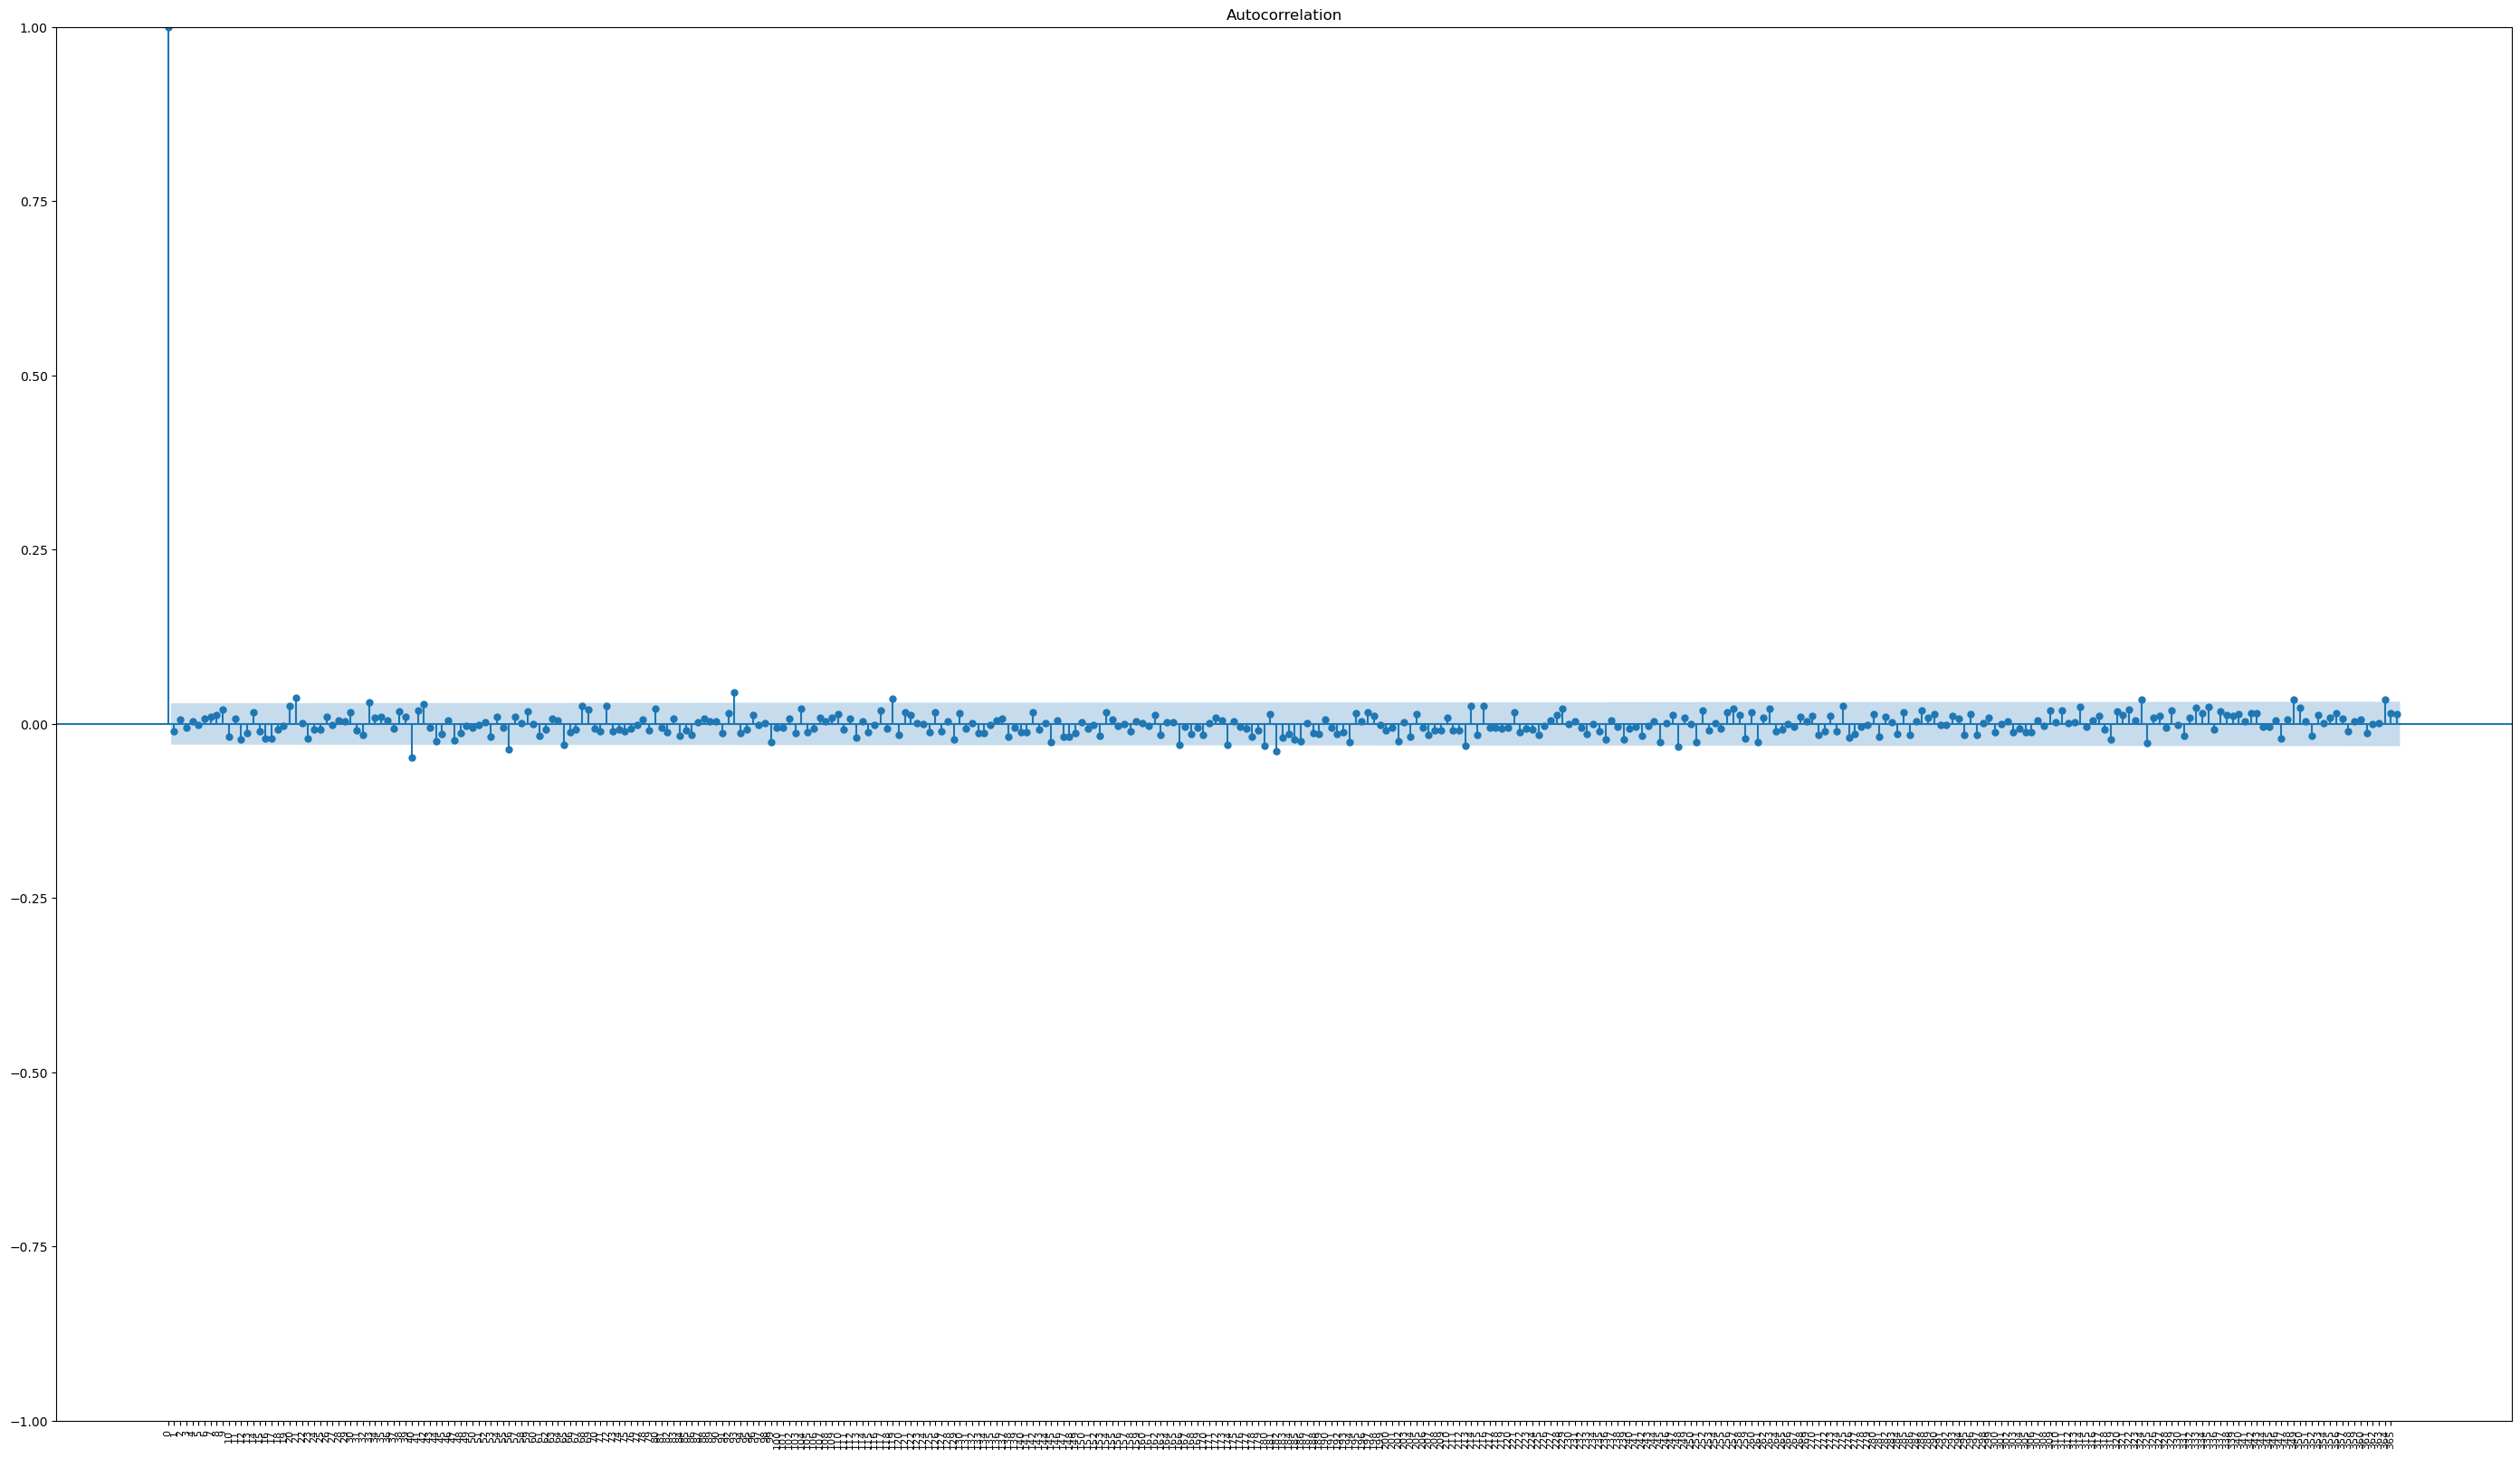

C:\Users\bro_1\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


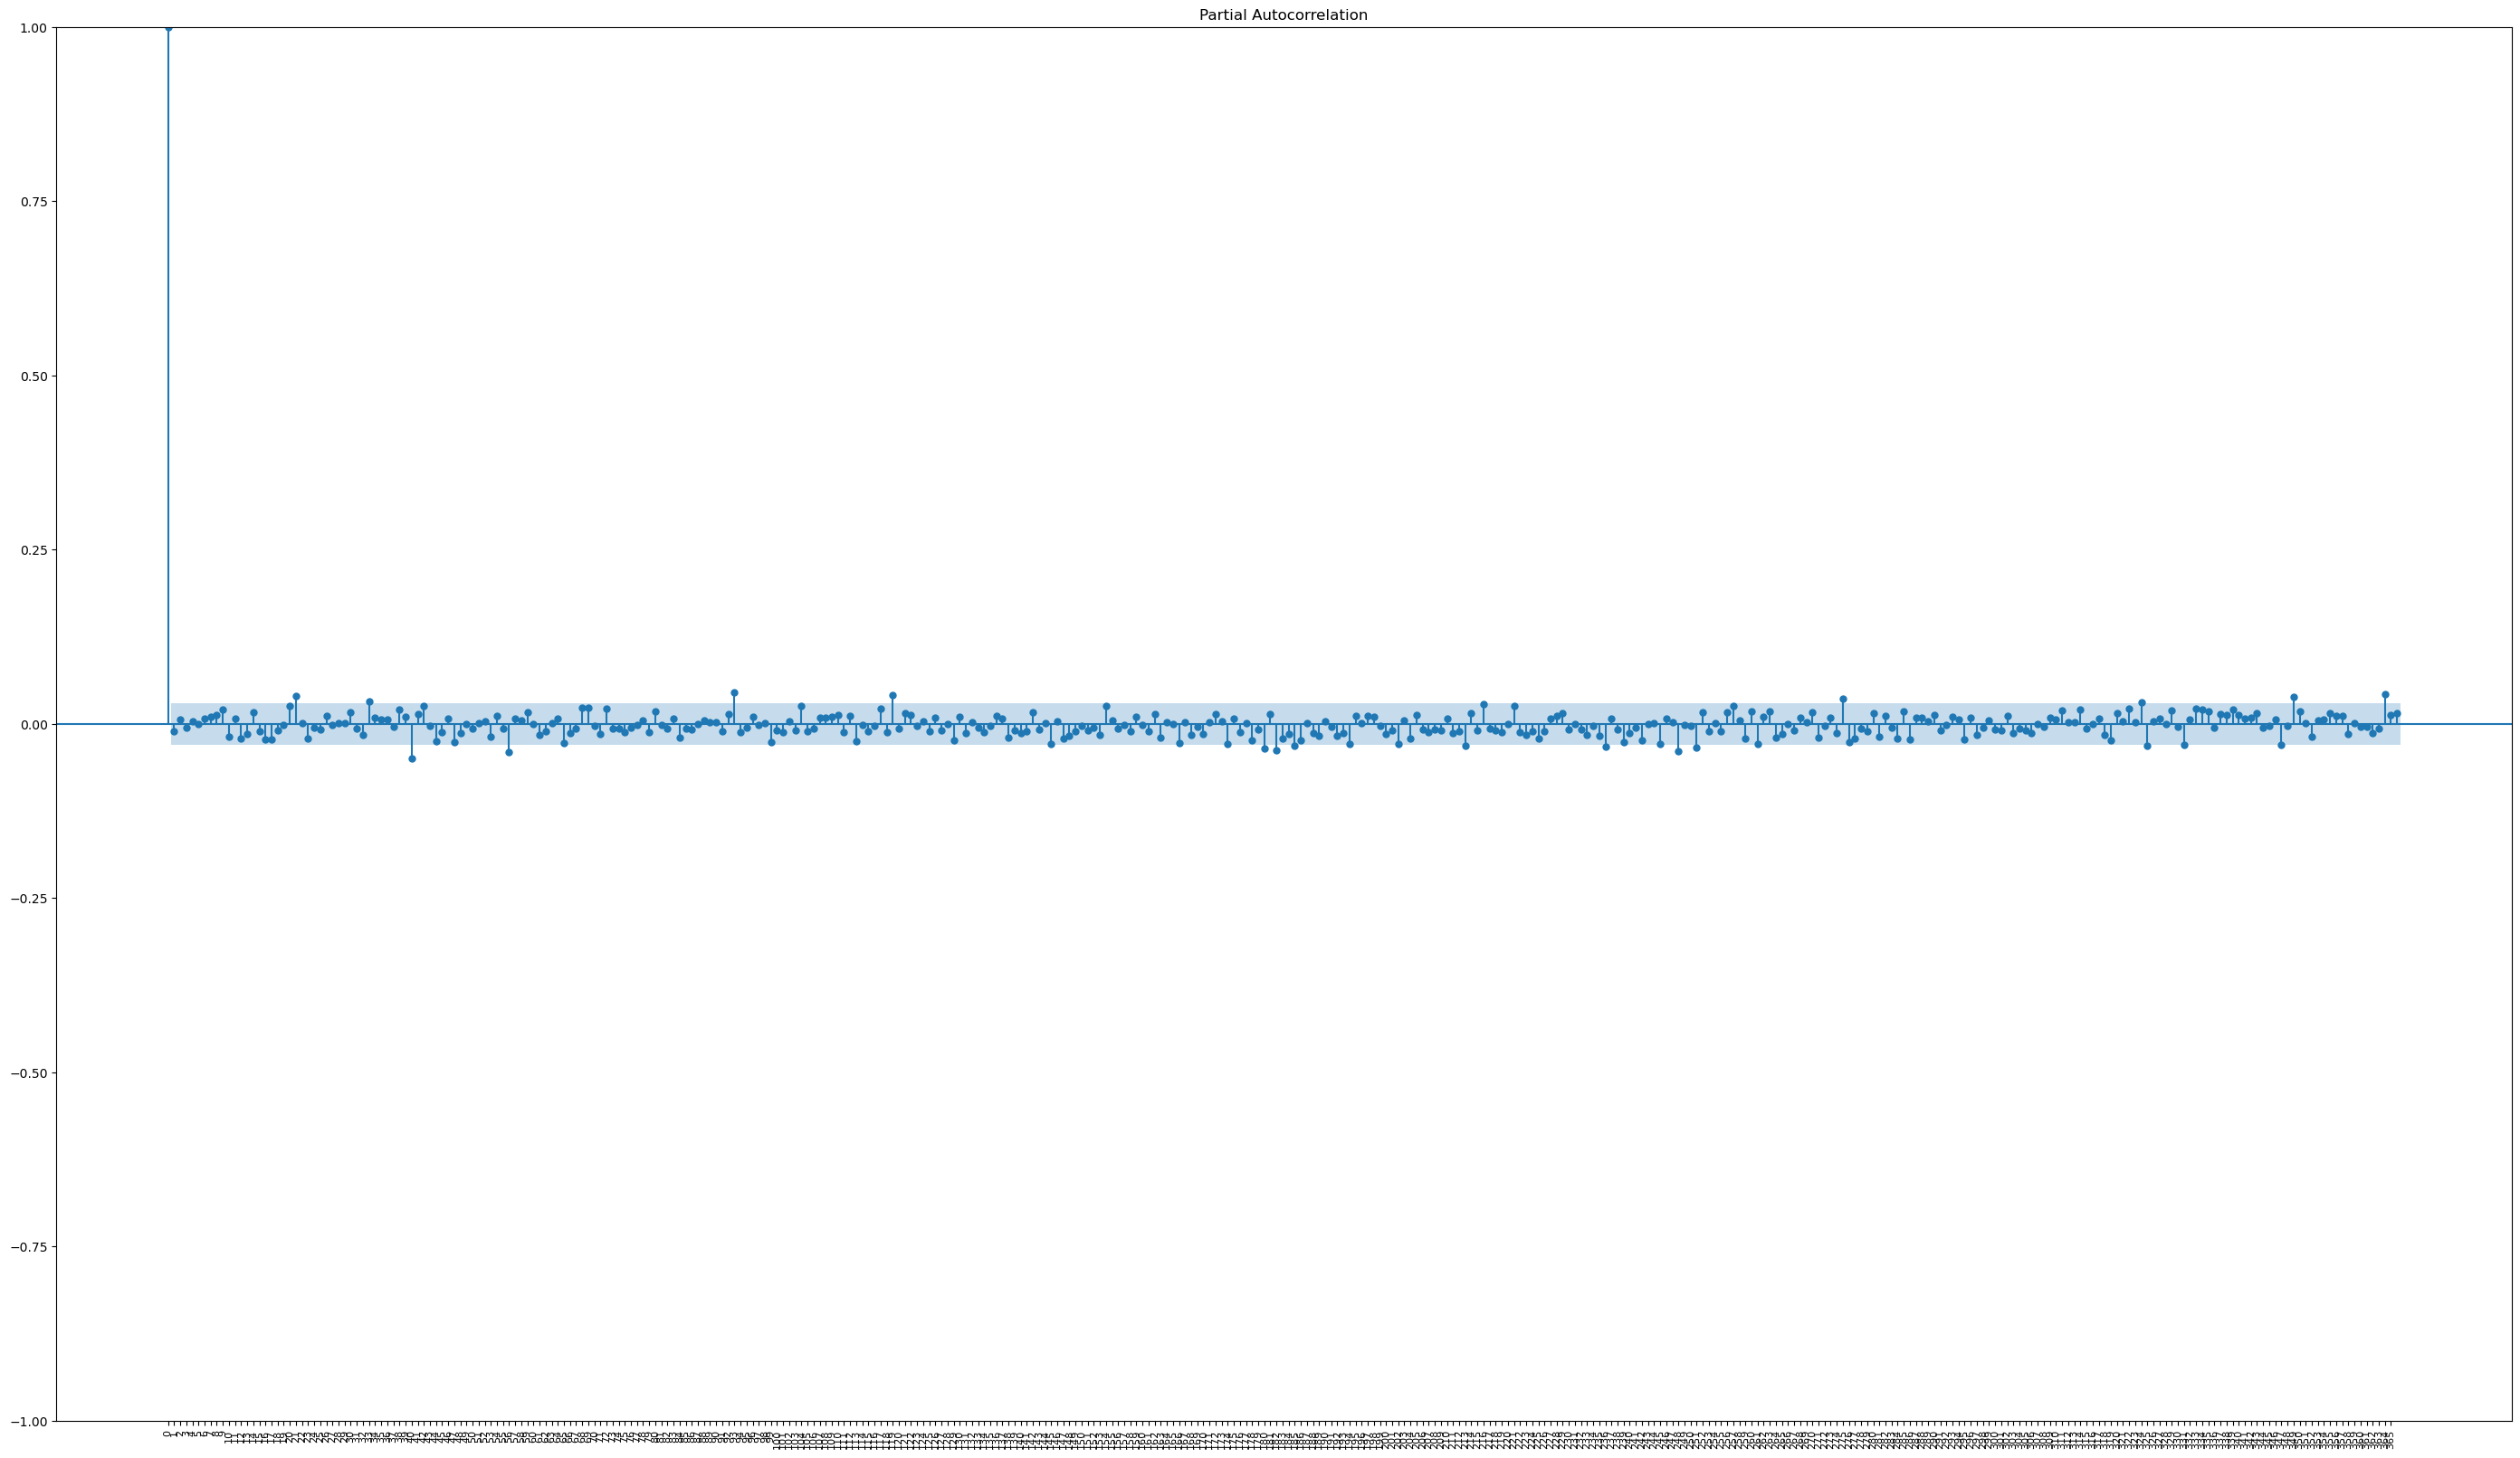

In [200]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
acf_plot = plot_acf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()


# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()

In [201]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 311.26


The MSE is very high, its 311.26

## Now we calculate the lagged values of Concentration (making a new variable with the value from day before, a week before, a month before, and a year before)

In [202]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)

# If 'Date' is not the index, you can use the following instead
# data['day_lag1'] = data['Concentration'].shift(1).reset_index(drop=True)

print(data.head())

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1           25.0          2        0     70.017711   
2008-01-02  2008      1    2           51.0          3        0     36.954496   
2008-01-03  2008      1    3           42.0          4        0     52.626476   
2008-01-04  2008      1    4           49.0          5        0     46.921039   
2008-01-05  2008      1    5           71.0          6        1     50.848344   

            day_lag1  day_lag7  
Date                            
2008-01-01       NaN       NaN  
2008-01-02      25.0       NaN  
2008-01-03      51.0       NaN  
2008-01-04      42.0       NaN  
2008-01-05      49.0       NaN  


In [203]:
# Assuming data is your DataFrame
data['day_lag30'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year']) & 
        (data['Month'] == row['Month'] - 1) & 
        (data['Day'] == row['Day']), 
        'Concentration'].iloc[0] if row['Month'] > 1 and not data.loc[
        (data['Year'] == row['Year']) & 
        (data['Month'] == row['Month'] - 1) & 
        (data['Day'] == row['Day']), 
        'Concentration'].empty else np.nan, axis=1
)

data['day_lag365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] - 1) & 
        (data['Month'] == row['Month']) & 
        (data['Day'] == row['Day']), 
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] - 1) & 
        (data['Month'] == row['Month']) & 
        (data['Day'] == row['Day']), 
        'Concentration'].empty else np.nan, axis=1
)

In [204]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 418.5336581709145
MSE for day_lag7 with dropped values: 921.5882308845577
MSE for day_lag30 with dropped values: 1068.68988005997
MSE for day_lag365 with dropped values: 1000.9648425787107


## Introduction of Holiday variable

In [205]:
# List of holiday dates with months and days
holiday_dates = {
    (1, 1),   # New Year's Day
    (1, 6),   # Epiphany
    (2, 14),  # Valentine's Day
    (3, 20),  # March Equinox
    (3, 29),  # Good Friday
    (3, 31),  # Easter Sunday
    (4, 1),   # Easter Monday
    (5, 1),   # Labor Day / May Day
    (5, 8),   # Iris Day (Brussels Regional holiday)
    (5, 9),   # Ascension Day
    (5, 10),  # Day after Ascension Day
    (5, 12),  # Mothers' Day
    (5, 19),  # Whit Sunday
    (5, 20),  # Whit Monday
    (6, 9),   # Fathers' Day
    (6, 20),  # June Solstice
    (7, 11),  # Day of the Flemish Community (Regional holiday in some provinces)
    (7, 21),  # Belgian National Day
    (8, 15),  # Assumption of Mary
    (9, 15),  # Day of the Walloon Region (Regional holiday in Namur)
    (9, 22),  # September Equinox
    (9, 27),  # Day of the French Community (Regional holiday in some provinces)
    (10, 27), # Daylight Saving Time ends
    (10, 31), # Halloween
    (11, 1),  # All Saints' Day
    (11, 11), # Armistice Day
    (11, 15), # Day of the German-speaking Community (Regional holiday in Liège)
    (12, 6),  # St. Nicholas Day
    (12, 21), # December Solstice
    (12, 24), # Christmas Eve
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (12, 31)  # New Year's Eve
}

# Create a new column 'IsHoliday' and set it to 1 for holidays, 0 otherwise
data['IsHoliday'] = data.apply(lambda row: 1 if (row['Month'], row['Day']) in holiday_dates else 0, axis=1)

# Display the updated DataFrame
print(data)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1           25.0          2        0     70.017711   
2008-01-02  2008      1    2           51.0          3        0     36.954496   
2008-01-03  2008      1    3           42.0          4        0     52.626476   
2008-01-04  2008      1    4           49.0          5        0     46.921039   
2008-01-05  2008      1    5           71.0          6        1     50.848344   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27           56.5          5        0     50.151538   
2019-12-28  2019     12   28           46.5          6        1     55.939282   
2019-12-29  2019     12   29           51.0          0        1     50.456584   
2019-12-30  2019     12   30           46.0          1        0     52.278797   
2019-12-31  2019     12   31

## Introduction of Season Variable

In [206]:
# Define the season based on the month with numerical values
data['Season'] = data['Month'].apply(lambda x: 
                                     1 if (x == 12 or x <= 2) else 
                                     2 if (x >= 3 and x <= 5) else 
                                     3 if (x >= 6 and x <= 8) else 
                                     4 if (x >= 9 and x <= 11) else None)

# Display the updated DataFrame
print(data)
data['Season'].unique()

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1           25.0          2        0     70.017711   
2008-01-02  2008      1    2           51.0          3        0     36.954496   
2008-01-03  2008      1    3           42.0          4        0     52.626476   
2008-01-04  2008      1    4           49.0          5        0     46.921039   
2008-01-05  2008      1    5           71.0          6        1     50.848344   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27           56.5          5        0     50.151538   
2019-12-28  2019     12   28           46.5          6        1     55.939282   
2019-12-29  2019     12   29           51.0          0        1     50.456584   
2019-12-30  2019     12   30           46.0          1        0     52.278797   
2019-12-31  2019     12   31

array([1, 2, 3, 4], dtype=int64)

## Removal of missing values?

In [207]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-02-12  2008      2   12            NaN          2        0     37.698784   
2008-02-13  2008      2   13            NaN          3        0     40.698590   
2008-02-14  2008      2   14            NaN          4        0     41.605198   
2008-05-18  2008      5   18            NaN          0        1     96.192812   
2009-03-24  2009      3   24            NaN          2        0     62.527797   
2009-03-25  2009      3   25            NaN          3        0     64.189752   
2009-10-20  2009     10   20            NaN          2        0     47.385703   
2009-10-21  2009     10   21            NaN          3        0     44.686424   
2013-02-26  2013      2   26            NaN          2        0     43.771935   
2013-02-27  2013      2   27            NaN          3   

In [208]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

# Display the modified data
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4305 entries, 2008-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4305 non-null   int64  
 1   Month          4305 non-null   int64  
 2   Day            4305 non-null   int64  
 3   Concentration  4305 non-null   float64
 4   DayOfWeek      4305 non-null   int64  
 5   Weekend        4305 non-null   int32  
 6   FittedValues   4305 non-null   float64
 7   day_lag1       4285 non-null   float64
 8   day_lag7       4249 non-null   float64
 9   day_lag30      3778 non-null   float64
 10  day_lag365     3868 non-null   float64
 11  IsHoliday      4305 non-null   int64  
 12  Season         4305 non-null   int64  
dtypes: float64(6), int32(1), int64(6)
memory usage: 454.0 KB
None


,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season
Date,,,,,,,,,,,,,
2008-01-01,2008,1,1,25.0,2,0,70.017711,NaN,NaN,NaN,NaN,1,1
2008-01-02,2008,1,2,51.0,3,0,36.954496,25.0,NaN,NaN,NaN,0,1
2008-01-03,2008,1,3,42.0,4,0,52.626476,51.0,NaN,NaN,NaN,0,1
2008-01-04,2008,1,4,49.0,5,0,46.921039,42.0,NaN,NaN,NaN,0,1
2008-01-05,2008,1,5,71.0,6,1,50.848344,49.0,NaN,NaN,NaN,0,1


In [209]:
###Now we interpolate the missing values of day_lag1, day_lag7, day_lag30 and day_lag365
# Assuming data_a is your DataFrame
columns_to_interpolate = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='polynomial', order=2)

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4305 entries, 2008-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4305 non-null   int64  
 1   Month          4305 non-null   int64  
 2   Day            4305 non-null   int64  
 3   Concentration  4305 non-null   float64
 4   DayOfWeek      4305 non-null   int64  
 5   Weekend        4305 non-null   int32  
 6   FittedValues   4305 non-null   float64
 7   day_lag1       4304 non-null   float64
 8   day_lag7       4298 non-null   float64
 9   day_lag30      4273 non-null   float64
 10  day_lag365     3943 non-null   float64
 11  IsHoliday      4305 non-null   int64  
 12  Season         4305 non-null   int64  
dtypes: float64(6), int32(1), int64(6)
memory usage: 454.0 KB


In [211]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1           25.0          2        0     70.017711   
2008-01-02  2008      1    2           51.0          3        0     36.954496   
2008-01-03  2008      1    3           42.0          4        0     52.626476   
2008-01-04  2008      1    4           49.0          5        0     46.921039   
2008-01-05  2008      1    5           71.0          6        1     50.848344   
2008-01-06  2008      1    6           65.0          0        1     64.976744   
2008-01-07  2008      1    7           73.0          1        0     61.956840   
2008-01-08  2008      1    8           62.0          2        0     66.980014   
2008-01-09  2008      1    9           69.0          3        0     62.658482   
2008-01-10  2008      1   10           57.0          4        0     65.112804   
2008-01-11  2008      1   11

In [212]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 388.11902689367065
MSE for day_lag7 with dropped values: 872.4143657757946
MSE for day_lag30 with dropped values: 1581.5181843050516
MSE for day_lag365 with dropped values: 956.0765116342083


In [213]:
##We remove the values from the year 2008
data = data[data['Year'] != 2008]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3943 entries, 2009-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3943 non-null   int64  
 1   Month          3943 non-null   int64  
 2   Day            3943 non-null   int64  
 3   Concentration  3943 non-null   float64
 4   DayOfWeek      3943 non-null   int64  
 5   Weekend        3943 non-null   int32  
 6   FittedValues   3943 non-null   float64
 7   day_lag1       3943 non-null   float64
 8   day_lag7       3943 non-null   float64
 9   day_lag30      3942 non-null   float64
 10  day_lag365     3943 non-null   float64
 11  IsHoliday      3943 non-null   int64  
 12  Season         3943 non-null   int64  
dtypes: float64(6), int32(1), int64(6)
memory usage: 415.9 KB


In [214]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2019-12-31  2019     12   31           43.0          2        0     49.689064   

            day_lag1  day_lag7  day_lag30  day_lag365  IsHoliday  Season  
Date                                                                      
2019-12-31      46.0      69.0        NaN        32.0          1       1  


In [215]:
data = data.dropna(subset=['day_lag30'])

## Now we normalize and Converge the signals (days) from euclidian to the angular domain

In [216]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns to normalize
columns_to_normalize = ['Concentration', 'FittedValues', 'day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Fit and transform the selected columns
data_normalized = data.copy()  # Make a copy to avoid modifying the original data
data_normalized[columns_to_normalize] = scaler.fit_transform(data_normalized[columns_to_normalize])

# Display the normalized data
print(data_normalized)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2009-01-01  2009      1    1       0.086316          4        0      0.033483   
2009-01-02  2009      1    2       0.040000          5        0      0.079803   
2009-01-03  2009      1    3       0.056842          6        1      0.038369   
2009-01-04  2009      1    4       0.115789          0        1      0.055714   
2009-01-05  2009      1    5       0.141053          1        0      0.105534   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-26  2019     12   26       0.189474          4        0      0.264102   
2019-12-27  2019     12   27       0.235789          5        0      0.209421   
2019-12-28  2019     12   28       0.193684          6        1      0.243889   
2019-12-29  2019     12   29       0.212632          0        1      0.211238   
2019-12-30  2019     12   30

In [217]:
## Assuming data_normalized is the DataFrame with normalized columns
#data_restored = data_normalized.copy()

# Inverse transform the selected columns
#data_restored[columns_to_normalize] = scaler.inverse_transform(data_normalized[columns_to_normalize])

# Display the restored data
#print(data_restored)

In [218]:
data_normalized.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season
Date,,,,,,,,,,,,,
2009-01-01,2009,1,1,0.086316,4,0,0.033483,0.018947,0.278136,0.338364,0.222015,1,1
2009-01-02,2009,1,2,0.040000,5,0,0.079803,0.086316,0.238905,0.359529,0.316980,0,1
2009-01-03,2009,1,3,0.056842,6,1,0.038369,0.040000,0.160441,0.379219,0.284108,0,1
2009-01-04,2009,1,4,0.115789,0,1,0.055714,0.056842,0.180057,0.397435,0.309675,0,1
2009-01-05,2009,1,5,0.141053,1,0,0.105534,0.115789,0.223212,0.414175,0.390030,0,1


In [219]:
data_normalized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3942 entries, 2009-01-01 to 2019-12-30
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3942 non-null   int64  
 1   Month          3942 non-null   int64  
 2   Day            3942 non-null   int64  
 3   Concentration  3942 non-null   float64
 4   DayOfWeek      3942 non-null   int64  
 5   Weekend        3942 non-null   int32  
 6   FittedValues   3942 non-null   float64
 7   day_lag1       3942 non-null   float64
 8   day_lag7       3942 non-null   float64
 9   day_lag30      3942 non-null   float64
 10  day_lag365     3942 non-null   float64
 11  IsHoliday      3942 non-null   int64  
 12  Season         3942 non-null   int64  
dtypes: float64(6), int32(1), int64(6)
memory usage: 415.8 KB
